In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import random

import librosa
import matplotlib.pyplot as plt
import numpy as np
import torch

import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
promonet.NUM_FFT = 4096
promonet.NUM_MELS = 256
promonet.WINDOW_SIZE = 4096

In [3]:
audio = promonet.load.audio('/hemera-storage1/pardo/max/test-audio/sitting.wav')[..., int(.2 * promonet.SAMPLE_RATE):int(6.2 * promonet.SAMPLE_RATE)]

In [20]:
# Compute pitch and periodicity
pitch, periodicity = promonet.preprocess.from_audio(
    audio,
    gpu=0,
    features=['pitch', 'periodicity'])
pitch, periodicity = pitch.cpu(), periodicity.cpu()

# Compute formants
formants = promonet.formants.from_audio(audio, pitch=pitch, gpu=0, max_formants=5).cpu()

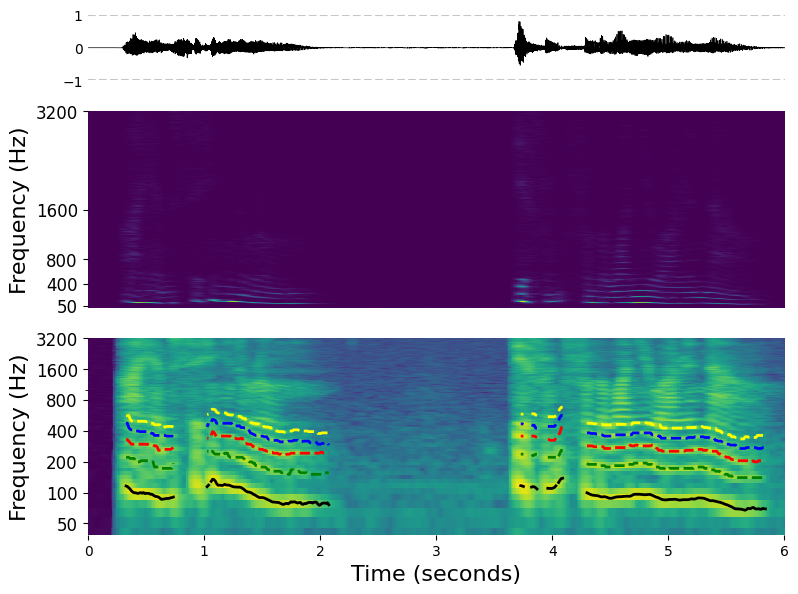

In [21]:
figure, axes = plt.subplots(3, 1, figsize=(9, 1.5 * 1.5 * 3), gridspec_kw={'height_ratios': [1, 3, 3]})

i = 0
axes[i].plot(audio.squeeze().cpu(), color='black', linewidth=.5)
axes[i].set_xmargin(0.)
axes[i].spines['top'].set_visible(False)
axes[i].spines['right'].set_visible(False)
axes[i].spines['bottom'].set_visible(False)
axes[i].spines['left'].set_visible(False)
axes[i].set_xticks([])
axes[i].set_ylim([-1., 1.])
axes[i].tick_params(axis=u'both', which=u'both', length=0)
for tick in [-1., 1.]:
    axes[i].hlines(tick, xmin=0., xmax=audio.shape[-1], color='#aaaa', linestyle='--')

i += 1
features = promonet.preprocess.spectrogram.from_audio(audio).cpu().numpy()
times = np.linspace(
    0,
    promonet.convert.samples_to_seconds(audio.shape[-1]),
    features.shape[-1])
frequencies = torch.abs(torch.fft.fftfreq(
    promonet.NUM_FFT,
    1 / promonet.SAMPLE_RATE
)[:promonet.NUM_FFT // 2 + 1])
axes[i].pcolormesh(times, frequencies[3:], features[3:-1, :-1])
axes[i].set_yticks([50, 400, 800, 1600, 3200], ['50', '400', '800', '1600', '3200'], fontsize=12)
axes[i].set_ylim(frequencies[3], 3200)
for spine in axes[i].spines.values():
    spine.set_visible(False)
axes[i].set_xticks([])
axes[i].set_ylabel('Frequency (Hz)', fontsize=16)

i += 1
features = promonet.preprocess.spectrogram.from_audio(audio, mels=True).cpu().numpy()

frequencies = librosa.mel_frequencies(promonet.NUM_MELS + 2, fmax=promonet.SAMPLE_RATE // 2)
axes[i].pcolormesh(times, frequencies[3:-1], features[2:])
axes[i].set_yscale('symlog')
axes[i].set_yticks([50, 100, 200, 400, 800, 1600, 3200], ['50', '100', '200', '400', '800', '1600', '3200'], fontsize=12)
axes[i].set_ylim(frequencies[3], 3200)
for spine in axes[i].spines.values():
    spine.set_visible(False)
axes[i].set_xlabel('Time (seconds)', fontsize=16)
axes[i].set_ylabel('Frequency (Hz)', fontsize=16)
    
# Overlay pitch
unvoiced = periodicity[0] < promonet.VOICING_THRESHOLD
x = torch.clone(pitch).squeeze()
x[unvoiced] = float('nan')
axes[i].plot(times, x, linewidth=2, color='black', label='Pitch')

# Overlay formants
colors = ['green', 'red', 'blue', 'yellow', 'teal']
for j, formant in enumerate(formants[1:]):
    x = torch.clone(formant)
    x[unvoiced] = float('nan')
    axes[i].plot(
        times,
        x,
        linewidth=2,
        color=colors[j],
        linestyle='--',
        label=f'F{j}')

figure.savefig('/hemera-storage1/pardo/max/thesis/mels.png', bbox_inches='tight', pad_inches=0)

torch.Size([1, 516]) torch.Size([1, 516])
torch.Size([1, 516]) torch.Size([1, 516])
torch.Size([516]) (516,)


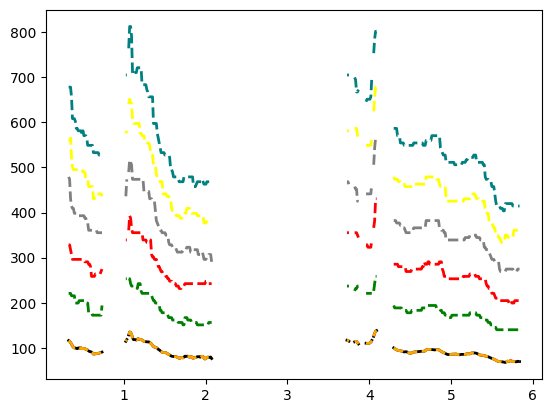

In [12]:
# Compute pitch and periodicity
pitch, periodicity = promonet.preprocess.from_audio(
    audio,
    gpu=0,
    features=['pitch', 'periodicity'])
pitch, periodicity = pitch.cpu(), periodicity.cpu()
print(pitch.shape, periodicity.shape)

# Compute formants
formants, features = promonet.formants.from_audio(audio, pitch=pitch, gpu=0, max_formants=6, return_features=True)
formants, features = formants.cpu(), features.cpu()
    
# Compute frame times
times = np.linspace(
    0,
    promonet.convert.samples_to_seconds(audio.shape[-1]),
    features.shape[-1])

# Overlay pitch
unvoiced = periodicity[0] < promonet.VOICING_THRESHOLD
x = torch.clone(pitch).squeeze()
x[unvoiced] = float('nan')
plt.plot(times, x, linewidth=2, color='black', label='Pitch')

# Overlay formants
colors = ['orange', 'green', 'red', 'gray', 'yellow', 'teal']
for j, formant in enumerate(formants):
    x = torch.clone(formant)
    x[unvoiced] = float('nan')
    plt.plot(
        times,
        x,
        linewidth=2,
        color=colors[j],
        linestyle='--',
        label=f'F{j}')